In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
df = pd.DataFrame([])
x1 = []
x1 += list(np.random.uniform(0,20,10))
x1 += list(np.random.uniform(10,30,10))
x1 += list(np.random.uniform(20,40,10))
x1 += list(np.random.uniform(30,50,10))
x1 += list(np.random.uniform(40,60,10))
df["x1"] = x1
x2 = []
x2 += list(np.random.uniform(10,30,10))
x2 += list(np.random.uniform(20,40,10))
x2 += list(np.random.uniform(10,30,10))
x2 += list(np.random.uniform(30,60,10))
x2 += list(np.random.uniform(0,30,10))
df["x2"] = x2
y = []
y += ["a"]*10
y += ["b"]*10
y += ["c"]*10
y += ["d"]*10
y += ["e"]*10
df["y"] = y

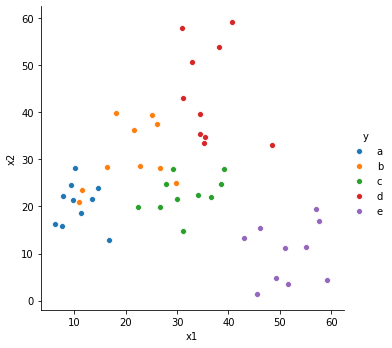

In [28]:
import seaborn as sns
sns.pairplot(x_vars=["x1"],y_vars=["x2"], data=df, hue="y", size=5)

In [29]:
df.head()

,x1,x2,y
0,11.374964,18.663167,a
1,10.151294,28.214143,a
2,9.830754,21.315352,a
3,13.493922,21.563596,a
4,16.674071,12.925849,a


In [30]:
from pandas.api.types import is_numeric_dtype
def is_numeric(df, col):
    return is_numeric_dtype(df[col])

In [31]:
class Partition:
    def __init__(self, column, value):
        self.column = column
        self.value = value
    def split_df(self, df):
        v = df[self.column]
        if is_numeric(df, self.column):
            return df[v<= self.value], df[v > self.value]
        else:
            return df[v == self.value],df[v != self.value]

In [32]:
p = Partition("x1", 30)

In [33]:
df_left, df_right = p.split_df(df)

In [34]:
df_right

,x1,x2,y
22,39.033622,27.885096,c
25,33.981330,22.467979,c
26,30.084814,21.641122,c
27,31.161350,14.699766,c
28,38.490413,24.751276,c
29,36.603909,21.906183,c
30,40.629559,59.198455,d
31,31.098099,42.979587,d
32,34.439971,35.280627,d
33,38.112954,53.759159,d


In [35]:
def gini(df_partitioned, target_col):
    counts = df_partitioned[target_col].value_counts()
    gini = 1
    for k,v in counts.iteritems():
        gini -=(v/len(df_partitioned))**2
    return gini

In [36]:
gini(df_left, "y")

0.6249999999999999

In [37]:
df_toy = df[df["y"]=="a"]
gini(df_toy,"y")

0.0

In [38]:
gini(df,"y")

0.7999999999999998

In [39]:
def information_gain(left,right, current_impurity, target):
    p = float(len(left))/(len(left)+len(right))
    gain = current_impurity - (p*gini(left, target) + (1-p)*gini(right, target))
    return gain

In [40]:
first_impurity = gini(df, "y")
p = Partition("x1", 30)
df_left, df_right = p.split_df(df)
information_gain(df_left, df_right, first_impurity, "y")

0.1615384615384614

In [41]:
def find_best_split(df, target):
    max_gain = 0
    best_split = None
    current_impurity = gini(df, target)
    columns = [e for e in df.columns.tolist() if e != target]
    for col in columns:
        values = set(df[col].values)
        for value in values:
            p = Partition(col, value)
            df_left, df_right = p.split_df(df)
            if len(df_left)==0 or len(df_right) == 0:
                continue
            gain = information_gain(df_left,df_right,current_impurity, target)
            if gain > max_gain:
                max_gain = gain
                best_split = [col, value]
    return best_split, max_gain

In [42]:
best_split, max_gain = find_best_split(df, "y")

In [43]:
max_gain

0.1790209790209789

In [44]:
best_split

['x1', 40.629558912358306]

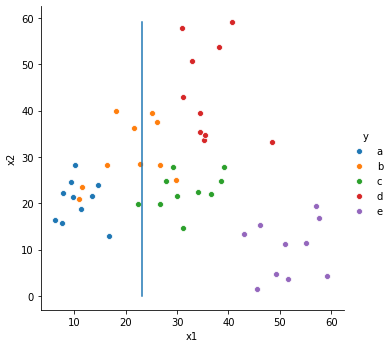

In [45]:
import seaborn as sns
sns.pairplot(x_vars=["x1"],y_vars=["x2"],data=df,hue="y",size=5)
plt.plot([23.149067567262026 for e in range(60)],[e for e in range(0,60)])

In [46]:
class Leaf:
    def __init__(self, df, target):
        self.results = df[target].value_counts()/len(df)*100
        
class DecisionNode:
    def __init__(self, best_split, left_decision, right_decision):
        self.best_split = best_split
        self.left_decision = left_decision
        self.right_decision = right_decision

In [47]:
def make_decision_tree(df, target):
    best_split, gain = find_best_split(df, target)
    if gain == 0 or gain is None:
        return Leaf(df, target)
    p = Partition(*best_split)
    left, right = p.split_df(df)
    left_decision = make_decision_tree(left, target)
    right_decision = make_decision_tree(right, target)
    return DecisionNode(best_split, left_decision, right_decision)

In [48]:
tree = make_decision_tree(df,"y")

In [49]:
def predict(node, df):
    if isinstance(node, Leaf):
        return node.results
    col, value = node.best_split
    if is_numeric(df, col):
        if df[col] <= value:
            return predict(node.left_decision, df)
        else:
            return predict(node.right_decision, df)
    else:
        if df[col] == value:
            return predict(node.left_decision, df)
        else:
            return predict(node.right_decision, df)

In [50]:
df.iloc[0]

x1     11.375
x2    18.6632
y           a
Name: 0, dtype: object

In [51]:
predict(tree, df.iloc[0])

a    100.0
Name: y, dtype: float64

In [52]:
df_test = pd.DataFrame([])
x1 = []
x1 += list(np.random.uniform(0,20,10))
x1 += list(np.random.uniform(10,30,10))
x1 += list(np.random.uniform(20,40,10))
x1 += list(np.random.uniform(30,50,10))
x1 += list(np.random.uniform(40,60,10))
df_test["x1"] = x1
x2 = []
x2 += list(np.random.uniform(10,25,10))
x2 += list(np.random.uniform(25,40,10))
x2 += list(np.random.uniform(0,30,10))
x2 += list(np.random.uniform(30,35,10))
x2 += list(np.random.uniform(13,17,10))
df_test["x2"] = x2
y = []
y += ["a"]*10
y += ["b"]*10
y += ["c"]*10
y += ["d"]*10
y += ["e"]*10
df_test["y"] = y

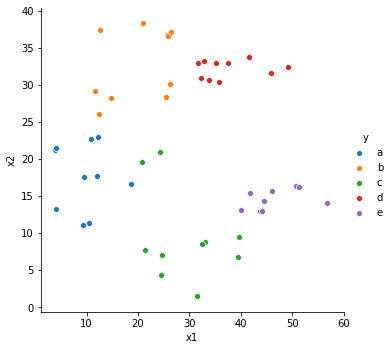

In [53]:
import seaborn as sns
sns.pairplot(x_vars=["x1"], y_vars=["x2"],data=df_test,hue="y",size=5)

In [54]:
correct = 0
for i in range(len(df_test)):
    if predict(tree, df_test.iloc[i]).index[0] == df_test.iloc[i]["y"]:
        correct += 1
correct/len(df_test)

0.9

In [56]:
correct = 0
for i in range(len(df)):
    if predict(tree, df.iloc[i]).index[0] == df.iloc[i]["y"]:
        correct += 1
correct/len(df_test)

1.0